In [1]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# load helper functions
%run -i "0. Functions_Clases Pipeline.py"
%run -i "Line.py"

# Load Camera calibration params
[ret, mtx, dist, rvecs, tvecs] = pickle.load(open( "pickle_data/camera_calibration_params.p", "rb" ) )


[NbConvertApp] Converting notebook 0. Functions_Clases Pipeline.ipynb to script
[NbConvertApp] Writing 20608 bytes to 0. Functions_Clases Pipeline.py


In [2]:
def test_frame(img):
    ###### Resize image
    img = resizeImage(img)

    ###### Undistort image
    undistorted = undistort_image(img, mtx, dist)
  
    ###### Color Enhancement

    imageCE = colorEnhancement(img)
   
    ###### GrayScale
    imageGray = grayscale(imageCE)


    ###### Gauss Smoothing
    imageGauss = gaussian_blur(imageGray,kernel_size=5) 
    
    #### Edge detection
    sbinary = sobel_thresh(imageGauss, sobel_kernel=5, x_thresh=[80,100], y_thresh=[40,100], 
                           mag_thresh=[50,255], dir_thresh=[100,200])

    #### ROI
    ysize =sbinary.shape[0]
    xsize =sbinary.shape[1]

    ROI_upperWidth = 280 #Width of the upper horizontal straight in px
    ROI_upperHeight = 260 #Height of the upper horizontal straight from the bottom of the image in px
    ROI_lowerWidth = 950 #Width of the lower horizontal straight in px
    ROI_lowerHeight = 50  #Height of the lower horizontal straight  from the bottom of the image in px      

    limitLL = ((xsize/2)-(ROI_lowerWidth/2),ysize-ROI_lowerHeight);
    limitLR = (xsize - ((xsize/2)-(ROI_lowerWidth/2)),ysize-ROI_lowerHeight);
    limitUL = ((xsize/2)-(ROI_upperWidth/2), ysize-ROI_upperHeight);
    limitUR = ((xsize/2)+(ROI_upperWidth/2), ysize-ROI_upperHeight);
    vertices = np.array([[limitLL,limitUL,limitUR , limitLR]], dtype=np.int32)
    
    imageROI = region_of_interest(sbinary,vertices)

    
    #### Perspective transform
    warped_img,M, Minv = warp_image(imageROI, hwidth = 250 ,offset = 0, height = -300, )
    
    out = np.dstack((warped_img*255, warped_img*255, warped_img*255))
    return out

In [3]:
# Instanciate cLine classes
lineLeft = Line()
lineRight = Line()


challenge_output2 = 'output_videos/challenge_video_2.mp4'
clip2 = VideoFileClip("test_videos/challenge_video.mp4")

challenge_clip = clip2.fl_image(test_frame) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output2, audio=False)

t:   0%|                                                             | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/challenge_video_2.mp4.
Moviepy - Writing video output_videos/challenge_video_2.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_video_2.mp4
Wall time: 1min 14s


In [4]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output2))

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

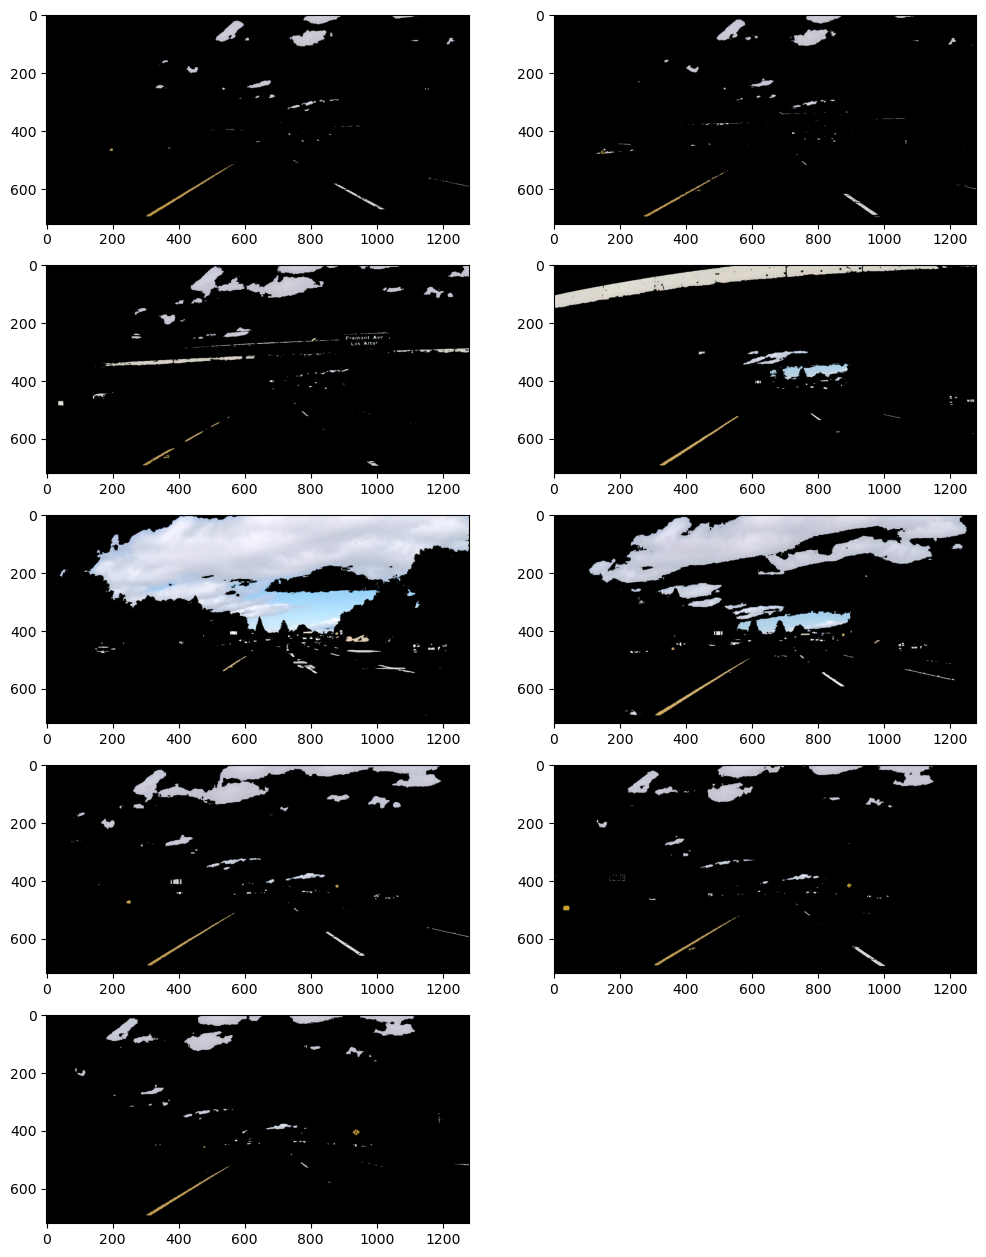

In [6]:
def colorEnhancement(img):
    """Converts the image to HSL
    Creates two masks to filter white and
    lleyow lines
    Applies the mask
    Be carefull to input an 8bit image!
    cv2.IMREAD_COLOR is your friend when using imgread
    """
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    ##find lleyows
    color1_hls = (90, 120, 80)
    color2_hls = (110, 255, 255)
    mask1 = cv2.inRange(hls, color1_hls,color2_hls)
    
    #find whites
    color1_hls_w = (0, 199, 0)
    color2_hls_w = (180, 255, 255)
    mask2 = cv2.inRange(hls, color1_hls_w,color2_hls_w)
    
    #    Add masks together
    mask = cv2.bitwise_or(mask1, mask2)
    
    res = cv2.bitwise_and(img,img, mask= mask)
    return res
hls_frames=[]
imgs = glob.glob('test_video_frames/*.png')


for idx, fname in enumerate(imgs):
    img = cv2.imread(fname)
    rgbimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagehls = colorEnhancement(rgbimg)
    hls_frames.append(imagehls)
    

        
displayListImages(hls_frames,cols=2,cmap=None,figSize=[12,8])